<h1>Análise dos dados gerados em <strong> gen.csv </strong> </h1>

<h2>
A base de dados escolhida consiste em um conjunto de dados que descrevem a rotina de compra de um ecommerce. Nela podemos visualizar diversas características de um produto, como o nome, preço, descrição, nota atribuída, comentários, local de compra, etc.
</p>
Por ser tão abrangente, essa análise será limitada ao sistema de avaliação feito pelos clientes após a confirmação de entrega do produto. Assim, o consumidor pode dar nota de 1 a 5 para o produto, sendo 1 o mais baixo e 5 o mais alto. Além disso, os comentários avaliativos também foram considerados para essa análise.

</h2>


In [34]:
import warnings
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from wordcloud import WordCloud
from os.path import abspath
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

warnings.filterwarnings('ignore')
%matplotlib inline


# HYPERPARAMETERS
RANDOM_STATE = 9
TRAIN_SPLIT = 0.80
VOCABULARY = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE = 128
EPOCHS = 25
EARLY_STOPPING_CRITERIA = 3
DROPOUT = 0.4
LEARNING_RATE = 0.01
MOMENTUM = 0.9
M_ITER = 10000
N_JOBS = 4

# lendo dados que são gerados no review_database.ipynb
data_bin = pd.read_csv(abspath('./data/data_bin.gen.csv')
                       ).dropna(subset=['text'])
data_cat = pd.read_csv(abspath('./data/data_cat.gen.csv')
                       ).dropna(subset=['text'])

data_cat.head()


[nltk_data] Downloading package stopwords to /home/carlos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,Recebi bem antes do prazo estipulado.,5.0
1,Parabéns lojas lannister adorei comprar pela I...,5.0
2,aparelho eficiente. no site a marca do aparelh...,4.0
3,"Mas um pouco ,travando...pelo valor ta Boa.\n",4.0
4,"Vendedor confiável, produto ok e entrega antes...",5.0


<h2> Plotando o gráfico de distribuição das notas dos clientes [1,5]</h2>


In [35]:
def plotBars(data, x_title, y_title):
    fig = px.bar(x=np.unique(data["label"]),
                 y=[list(data["label"]).count(i)
                    for i in np.unique(data["label"])],
                 color=np.unique(data["label"]),
                 color_continuous_scale=px.colors.carto.Agsunset_r)

    fig.update_xaxes(title=x_title)
    fig.update_yaxes(title=y_title)
    fig.update_layout(showlegend=True,
                      autosize=False,
                      width=800,
                      height=500,
                      title={
                          'text': f'{x_title} pelo {y_title}',
                          'y': 0.95,
                          'x': 0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                      )
    fig.show()


plotBars(data_cat, 'Avaliações', 'Número de Avaliações')


<h2> Plotando o gráfico de distribuição binárias das notas, sendo 0 não gostou e 1 aprovou o pedido</h2>


In [36]:
plotBars(data_bin, 'Avaliações (binário)', 'Número de reviews')


<h2>Fazendo uma nuvem das palavras mais usadas nos comentários das avaliações</h2>


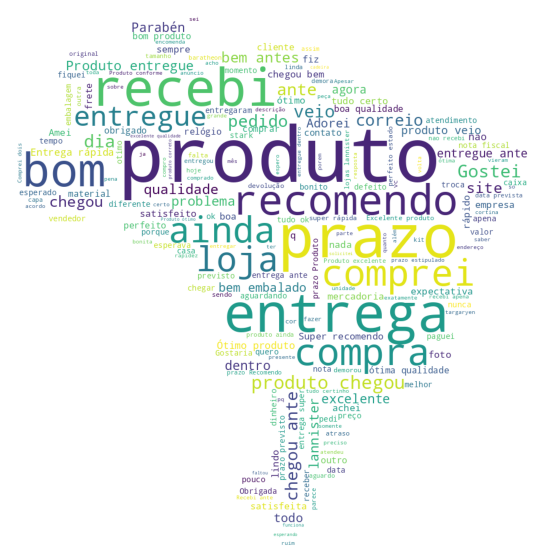

In [37]:
mask = np.array(Image.open('./data/mask.jpg'))
words = stopwords.words('portuguese')
words.extend(['porém', 'pois', 'pra'])
wordcloud = WordCloud(stopwords=words,
                      background_color='white',
                      mask=mask).generate(' '.join(data_cat["text"]))
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.axis('off')
plt.imshow(wordcloud)


<h2>Craição de função para dividir dataset em test e treinamento além de preprocessamento</h2>


In [39]:
def split_dataset(dataset, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    train = dataset.sample(frac=split_train, random_state=random_state)
    test = dataset.drop(train.index)

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for _, t in train.iterrows():
        x_train.append(str(t['text']))
        y_train.append(t['label'])

    for _, t in test.iterrows():
        x_test.append(str(t['text']))
        y_test.append(t['label'])

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split_dataset(data_bin)


def preprocess(X_train, X_test, length, vocab_size, trunc_type='post'):

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="token_ovv", lower=True)
    tokenizer.fit_on_texts(x_train)
    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_pad = pad_sequences(
        training_sequences, maxlen=length, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(X_test)
    print(testing_sequences)
    X_test_pad = pad_sequences(testing_sequences, maxlen=length)

    return X_train_pad, X_test_pad


x_train, x_test = preprocess(x_train, x_test, MAX_LENGTH, VOCABULARY)
print(x_test)


[[29, 20, 138, 4644, 82, 167, 800, 61, 22], [146, 11, 152, 4, 573], [16, 224, 2, 9, 160, 54, 329, 1181, 6, 359, 1807, 2998, 29, 133, 15, 17, 10], [2, 3, 8, 15, 17, 10, 235, 4, 3439, 860, 287, 1, 5, 1610, 6, 5633, 7, 40, 553, 6029, 17, 10, 1175, 31, 5694, 4, 191, 26, 1, 3367, 74, 5, 206, 71, 2821], [3, 11, 417, 404, 892], [1609], [4910], [1339, 6, 402, 73, 370, 13, 1, 4006, 22, 22, 11, 162], [255, 18, 2, 2890, 2341, 13, 1, 334, 1, 6, 635, 75, 4008, 848, 731, 579, 475, 8, 18, 24, 22, 871, 4, 24, 1, 342, 6, 3148, 2575, 1, 6480, 334, 2180, 95, 4008, 848, 4735, 1556, 255, 18, 4859], [316, 95, 3, 4, 53, 9, 16, 95, 27, 371], [231, 56, 455], [48, 3], [46, 74, 8, 16, 2, 3], [78, 28, 36, 4, 3980, 260, 6, 105, 729, 20, 138], [2, 397, 6, 572, 19, 114, 41, 152, 7, 9, 31, 135, 107], [36, 257, 7, 119, 70, 11, 318, 2, 3, 2571, 286, 497, 77, 822, 28, 179, 31, 606, 206], [3, 6, 34, 4, 687, 31, 12, 16, 11, 14, 7, 210, 23], [124, 632, 24, 17, 10, 210, 819], [420, 90, 77, 4024], [89, 181, 5, 39, 7, 228, 10